In [637]:
#!pip install -q texttable

In [638]:
from tabulate import tabulate
from texttable import Texttable
import latextable

from SPARQLWrapper import SPARQLWrapper, JSON
from datetime import datetime
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
import statistics
from cdlib import algorithms

In [639]:
def drop_weights(G):
    '''Drop the weights from a networkx weighted graph.'''
    for node, edges in nx.to_dict_of_dicts(G).items():
        for edge, attrs in edges.items():
            attrs.pop('weight', None)

In [640]:
def similarita(voti_dep1, voti_dep2):
    uguali = np.sum((voti_dep1 == voti_dep2) & (voti_dep1 != 0) ) # volte in cui hanno votato la stessa  ed erano entrambi presenti

    diversi = np.sum((voti_dep1 != voti_dep2) & (voti_dep1 != 0) & (voti_dep2 != 0) ) # volte in cui hanno votato diversamente ed erano entrambi presenti
    
    if uguali == 0:
        sim = 0
    else:
        sim = uguali/(uguali+diversi)
    return sim

# Load dataset and pre-process, dropping noise rows

In [641]:
leg = 'xvii'
year = 'xvii leg'
#df = pd.read_csv(f'./{leg}-years/{leg}-{year}.csv')

df = pd.read_csv(f'./{leg}-years/{leg}-merged.csv')

df

,Parlamentare,id,Partito,dataIngresso,010001,013001,015006,015022,015017,015018,...,905003,905004,905005,905002,009003,009005,009004,009006,009002,009001
0,BERSANI PIER LUIGI,300026,MDP-LU,2017-02-28,1.0,0.0,3.0,0.0,3.0,3.0,...,3.0,3.0,3.0,1.0,4.0,4.0,4.0,0.0,4.0,3.0
1,LETTA ENRICO,300127,PD,2013-03-19,1.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,SERENI MARINA,300231,PD,2013-03-19,1.0,1.0,0.0,0.0,0.0,0.0,...,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,CATANOSO GENOESE FRANCESCO,300237,FI-PDL,2013-03-19,1.0,1.0,3.0,3.0,3.0,3.0,...,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,D'ALIA GIANPIERO,300239,DES-CD,2013-12-10,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
591,MAIETTA PASQUALE,306310,MISTO,2013-03-19,3.0,3.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
592,ZARATTI FILIBERTO,306521,MDP-LU,2017-02-28,3.0,3.0,0.0,0.0,0.0,0.0,...,3.0,3.0,3.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
593,SANNICANDRO ARCANGELO,306523,SI-SEL-POS-LU,2013-03-19,3.0,3.0,0.0,0.0,0.0,0.0,...,3.0,3.0,3.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
594,GUIDESI GUIDO,306582,LNA,2013-03-19,0.0,0.0,0.0,0.0,0.0,0.0,...,4.0,4.0,4.0,4.0,1.0,3.0,3.0,1.0,1.0,3.0


In [642]:
df.reset_index(inplace= True, drop = True)
indici = []
for i in range(df.shape[0]):
    if np.count_nonzero(df.iloc[i,4:]) < 0.3*(df.shape[1]-4):
        indici.append(i)


df.drop(indici, axis = 0, inplace = True)
df.reset_index(inplace= True, drop = True)
df.shape

(136, 24938)

# Graph based on similarity

In [643]:
m = np.array(df[df.columns[4:df.shape[1]]])
m.shape

(136, 24934)

Create Adjacency Matrix

In [644]:
A = np.zeros((len(m),len(m))) #inizializzo matrice a 0
i=0
j=0
for i in range(len(m)):
    for j in range(len(m)):
        A[i,j] = similarita(m[i],m[j])

### Cumulative distribution function

In [645]:
unique_scores, counts = np.unique(A, return_counts=True)
distribution = dict(zip(unique_scores, counts / np.sum(counts)))

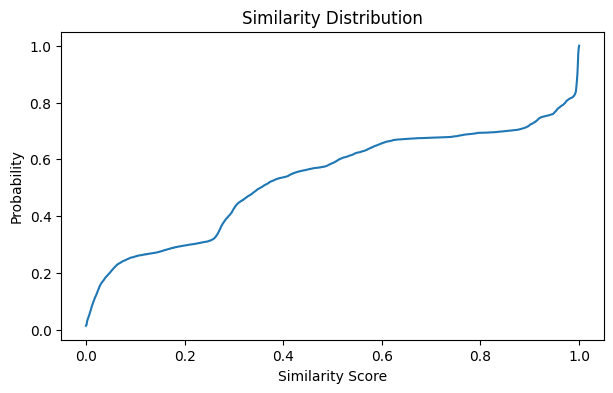

In [646]:
scores = list(distribution.keys())
probabilities = np.cumsum(list(distribution.values()))
plt.figure(figsize=(7,4))
plt.plot(scores, probabilities)
plt.xlabel('Similarity Score')
plt.ylabel('Probability')
plt.title('Similarity Distribution')
plt.show()


### Create Graph

In [647]:
G = nx.from_numpy_matrix(A)

print(G.number_of_nodes())
print(G.number_of_edges())
G.remove_edges_from(nx.selfloop_edges(G))
print(G.number_of_edges())
print(G.number_of_nodes())

#nx.draw(G, node_size = 1, width = 0.1)

136
9188
9052
136


In [648]:
par = {}
for i in G.nodes:
    par[i] = df['Partito'][i] 
    
nx.set_node_attributes(G, name = 'Partito', values = par)

In [700]:
F = G.copy()
tresh = np.percentile(A, q = 50)
print(tresh)
threshold = tresh
print(F.number_of_edges())
F.remove_edges_from([(n1, n2) for n1, n2, w in F.edges(data="weight") if w < threshold])
print(F.number_of_edges())
print(nx.is_weighted(F)) 

#nx.draw(F, node_size = 1, width = 0.1)
#plt.show()

0.3545571136957827
9052
4568
True


Remove weights

In [701]:
drop_weights(F)
print(nx.is_weighted(F)) 
#nx.draw(F, node_size = 1, width = 0.1)
#plt.show()


False


save for gephi, remove isolated nodes for visualization

In [702]:
'''
fg =  F.copy()
fg.remove_nodes_from(list(nx.isolates(fg)))
print(nx.is_weighted(fg)) 
nx.write_gexf( fg , 'xviii_graph.gexf' )
nx.draw(fg, node_size = 1, width = 0.1)
plt.show()
'''

"\nfg =  F.copy()\nfg.remove_nodes_from(list(nx.isolates(fg)))\nprint(nx.is_weighted(fg)) \nnx.write_gexf( fg , 'xviii_graph.gexf' )\nnx.draw(fg, node_size = 1, width = 0.1)\nplt.show()\n"

Degree Distribution Analysis

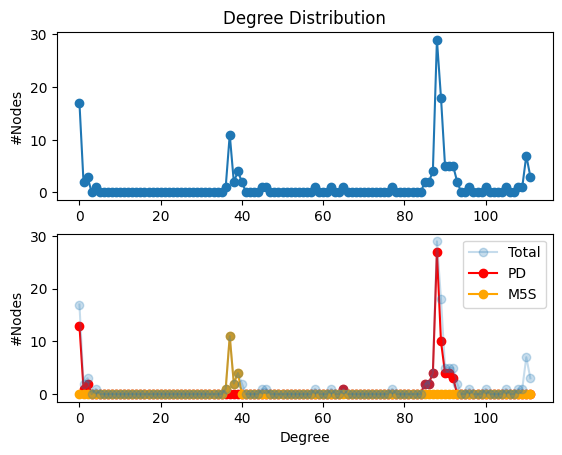

In [703]:
hist = nx.degree_histogram(F)   


plt.subplot(211)
plt.plot(range(0, len(hist)), hist, 'o-')
plt.title("Degree Distribution")
plt.ylabel("#Nodes")


plt.subplot(212)

plt.plot(range(0, len(hist)), hist, 'o-', zorder = 3, alpha = 0.25, label = 'Total')

pd = [x for x,y in F.nodes(data=True) if y['Partito']=='PD']
h = nx.degree(F, pd)
d = [item[1] for item in h]                 
hist_pd = np.histogram(d, bins = max(d))
h_pd = hist_pd[0]
h_pd = np.pad(h_pd, (min(d),len(hist)-len(h_pd)), 'constant')
plt.plot(range(0, len(h_pd)),h_pd, 'o-', color = 'red', label = 'PD')


m5s = [x for x,y in F.nodes(data=True) if y['Partito']=='M5S']
h = nx.degree(F, m5s)
d = [item[1] for item in h]   
hist_m5s = np.histogram(d, bins = max(d)-min(d))
h_m5s = hist_m5s[0]
h_m5s = np.pad(h_m5s, (min(d),len(hist)-max(d)), 'constant')
plt.plot(range(0, len(h_m5s)),h_m5s, 'o-', color = 'orange', label = 'M5S')
plt.xlabel("Degree")
plt.ylabel("#Nodes")
plt.legend()
plt.show()

In [704]:
print(f'Number of isolated nodes = {len(list(nx.isolates(F)))}')

Number of isolated nodes = 17


In [705]:
n_nodes = F.number_of_nodes()
n_edges = F.number_of_edges()
avg_deg = sum(dict(F.degree()).values())/float(len(F))
n_comps = nx.number_connected_components(F)
n_isol_nodes = len(list(nx.isolates(F)))
comps = list(nx.connected_components(F)) # get a list of connected components (for decreasing size)
avg_spl = nx.average_shortest_path_length(F.subgraph(comps[0])) #giant component
diam = nx.diameter(F.subgraph(comps[0])) # we compute the diameter on the giant component
avg_cc = nx.average_clustering(F) # compute the global clustering coefficient
density = nx.density(F)

To print the table in Latex:

In [706]:
rows = [['year','#nodes', '#edges', 'avg degree','#isol. nodes', '#conn. comps.','avg SPL','diameter', 'avg CC', 'Density'],
         [year,n_nodes,n_edges,avg_deg,n_isol_nodes,n_comps-n_isol_nodes, avg_spl, diam, avg_cc,density]]

In [707]:
print('Tabulate Table:')
print(tabulate(rows, headers='firstrow'))

table = Texttable()
table.set_deco(Texttable.HEADER | Texttable.VLINES)
table.add_rows(rows)

print(tabulate(rows, headers='firstrow', tablefmt='latex', floatfmt=".2f"))


Tabulate Table:
year        #nodes    #edges    avg degree    #isol. nodes    #conn. comps.    avg SPL    diameter    avg CC    Density
--------  --------  --------  ------------  --------------  ---------------  ---------  ----------  --------  ---------
xvii leg       136      4568       67.1765              17                1    1.37032           3  0.804177   0.497603
\begin{tabular}{lrrrrrrrrr}
\hline
 year     &   \#nodes &   \#edges &   avg degree &   \#isol. nodes &   \#conn. comps. &   avg SPL &   diameter &   avg CC &   Density \\
\hline
 xvii leg &      136 &     4568 &        67.18 &             17 &               1 &      1.37 &          3 &     0.80 &      0.50 \\
\hline
\end{tabular}


[0.0014023348454274365, 0.0, 0.03493334581132714, 9.084288345289508e-05, 0.0, 0.0, 0.00046878031549219527, 0.012898982686107502, 0.0, 5.6525299079849426e-05, 0.012370547018108883, 0.001284920090357419, 0.0, 0.0002643453168679937, 0.00039591592477953945, 0.0, 9.084288345289508e-05, 0.0002464597446775961, 0.012370547018108883, 9.084288345289508e-05, 0.0, 9.084288345289508e-05, 9.084288345289508e-05, 0.0007632444429268318, 0.0, 0.0002643453168679937, 0.0, 0.009794160848787502, 0.0, 0.0, 0.017046928865830233, 9.084288345289508e-05, 0.011858525245337195, 0.012898982686107502, 9.084288345289508e-05, 0.0002464597446775961, 5.6525299079849426e-05, 1.9421890068656242e-05, 0.0017253834624685832, 0.0002464597446775961, 4.9836480633984864e-05, 9.084288345289508e-05, 0.0007632444429268318, 0.014320493158791851, 0.0, 0.0003792942476500679, 0.0, 0.0006569198900265956, 8.861682804151351e-06, 8.861682804151351e-06, 0.01236987941366725, 0.0007632444429268318, 0.00030972618156891097, 0.000246459744677596

Text(0, 0.5, '#Nodes')

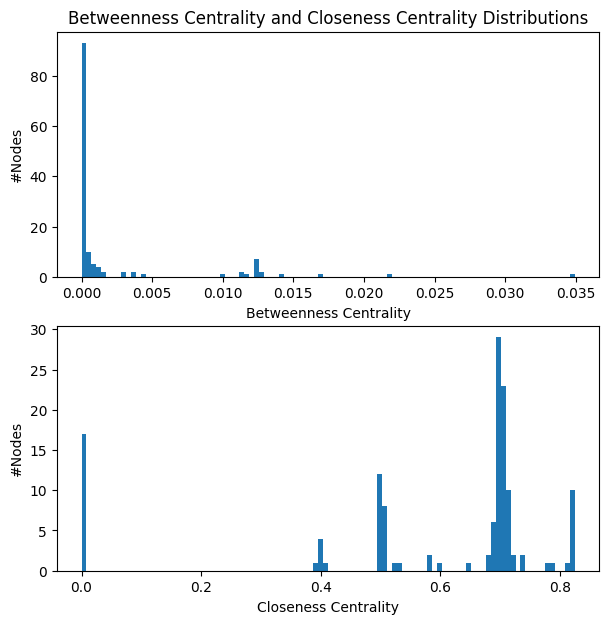

In [708]:
bw_c = nx.betweenness_centrality(F)
cl_c = nx.closeness_centrality(F)

bw = list(bw_c.values())
cl = list(cl_c.values())

print(bw)

plt.figure(figsize=(7,7))
plt.subplot(211)
plt.hist(bw, bins = 100)
plt.title("Betweenness Centrality and Closeness Centrality Distributions")
plt.xlabel("Betweenness Centrality")
plt.ylabel("#Nodes")
plt.subplot(212)
plt.hist(cl, bins = 100)
plt.xlabel("Closeness Centrality")
plt.ylabel("#Nodes")

## Changing the treshold

In [709]:
thresholds = np.linspace(0,1, 51)
print(thresholds)
_avg_deg = []
_n_edg = [] #number of edges
_conn_comps = [] #number of edges
_n_isol_nodes = []
_avg_spl = []
_avg_cc = []
_density = []

for threshold in thresholds:
    F = G.copy()
    #print(F.number_of_edges())
    F.remove_edges_from([(n1, n2) for n1, n2, w in F.edges(data="weight") if w < threshold])
    #print(F.number_of_edges())
    _deg = sum(dict(F.degree()).values())/float(len(F)) #avg degree
    _avg_deg.append(_deg)
    _n_edg.append(F.number_of_edges())
    _conn_comps.append(nx.number_connected_components(F))
    _n_isol_nodes.append(len(list(nx.isolates(F))))
    _comps = list(nx.connected_components(F)) # get a list of connected components (for decreasing size)
    _avg_spl.append(nx.average_shortest_path_length(F.subgraph(_comps[0]))) #giant component
    _avg_cc.append(nx.average_clustering(F)) # compute the global clustering coefficient
    _density.append(nx.density(F))


#plt.plot(thresholds, n_edg)
#plt.show()

[0.   0.02 0.04 0.06 0.08 0.1  0.12 0.14 0.16 0.18 0.2  0.22 0.24 0.26
 0.28 0.3  0.32 0.34 0.36 0.38 0.4  0.42 0.44 0.46 0.48 0.5  0.52 0.54
 0.56 0.58 0.6  0.62 0.64 0.66 0.68 0.7  0.72 0.74 0.76 0.78 0.8  0.82
 0.84 0.86 0.88 0.9  0.92 0.94 0.96 0.98 1.  ]


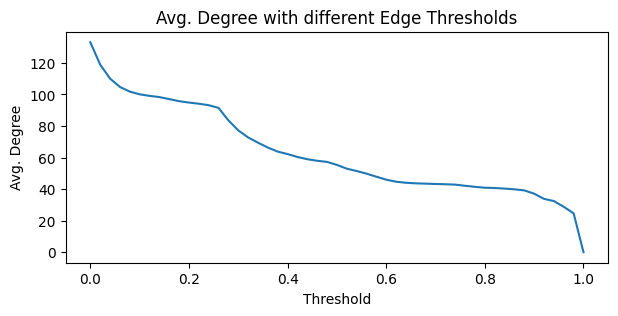

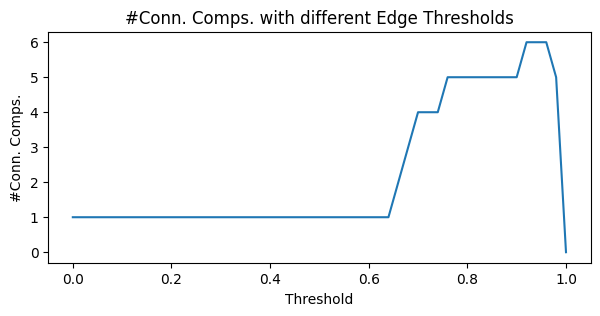

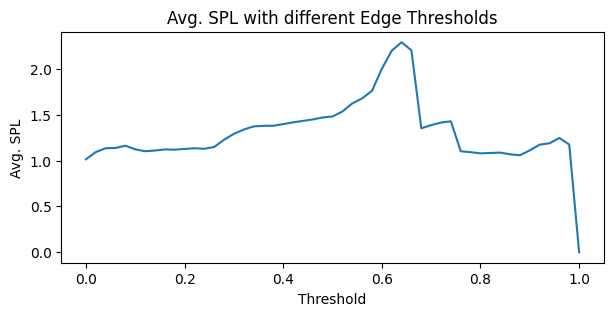

0.8041765916140646


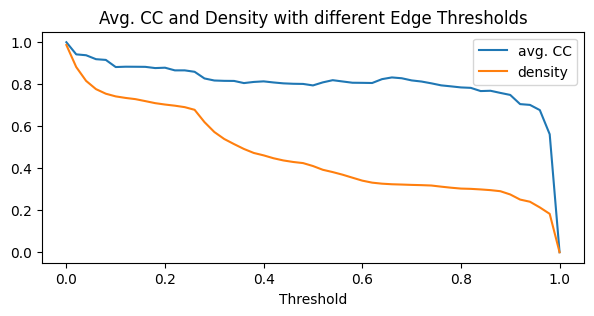

In [710]:
plt.figure(figsize=(7,3))
plt.plot(thresholds, _avg_deg)
plt.title('Avg. Degree with different Edge Thresholds')
plt.xlabel('Threshold')
plt.ylabel('Avg. Degree')
plt.show()



plt.figure(figsize=(7,3))
plt.plot(thresholds, np.array(_conn_comps)-np.array(_n_isol_nodes))
plt.title('#Conn. Comps. with different Edge Thresholds')
plt.xlabel('Threshold')
plt.ylabel('#Conn. Comps.')
plt.show()

plt.figure(figsize=(7,3))
plt.plot(thresholds, _avg_spl)
plt.title('Avg. SPL with different Edge Thresholds')
plt.xlabel('Threshold')
plt.ylabel('Avg. SPL')
plt.show()


plt.figure(figsize=(7,3))
plt.plot(thresholds,_avg_cc, label='avg. CC')
plt.title('Avg. CC and Density with different Edge Thresholds')
plt.xlabel('Threshold')
plt.plot(thresholds, _density, label = 'density')
print(avg_cc)
plt.xlabel('Threshold')
plt.legend()
plt.show()

# Comparison with syntetic graphs

# ER

136 4568 0.49760348583877995


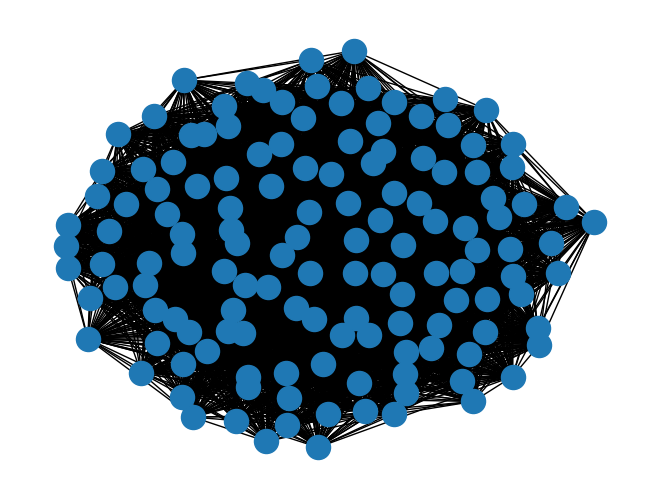

In [711]:
# network generators 1 (random graphs)
N = n_nodes
L = n_edges
p = (2*L/(N*(N-1)))
print(N,L,p)
er = nx.erdos_renyi_graph(F.number_of_nodes(), p)
nx.draw(er)

In [712]:
er_n_nodes = er.number_of_nodes()
er_n_edges = er.number_of_edges()
er_avg_deg = sum(dict(er.degree()).values())/float(len(er))
er_n_comps = nx.number_connected_components(er)
er_n_isol_nodes = len(list(nx.isolates(er)))
er_comps = list(nx.connected_components(er)) # get a list of connected components (for decreasing size)
er_avg_spl = nx.average_shortest_path_length(er.subgraph(er_comps[0])) #giant component
er_diam = nx.diameter(er.subgraph(er_comps[0])) # we compute the diameter on the giant component
er_avg_cc = nx.average_clustering(er) # compute the global clustering coefficient
er_density = nx.density(er)


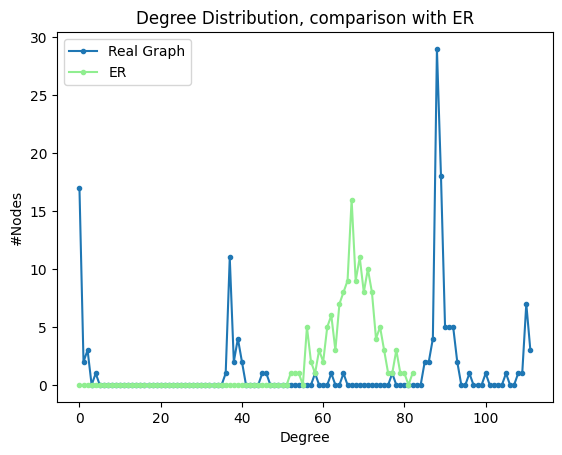

In [739]:
hist_er = nx.degree_histogram(er)
    
plt.plot(range(0, len(hist)), hist, '.-', label='Real Graph')
plt.title("Degree Distribution")
plt.ylabel("#Nodes")


plt.plot(range(0, len(hist_er)), hist_er, ".-", label='ER', color = 'lightgreen')
plt.title("Degree Distribution, comparison with ER")
plt.xlabel("Degree")
plt.ylabel("#Nodes")
plt.legend()
plt.show()

# BA

34


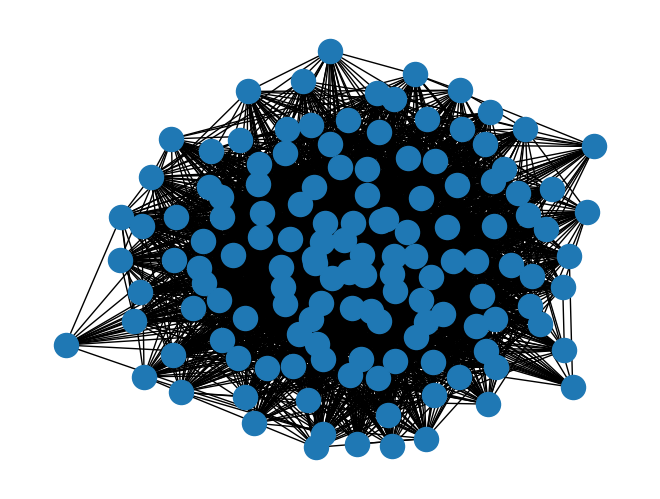

In [795]:
m = round(avg_deg/2)  # number of links each node establishes once joining the network
print(m)

ba = nx.barabasi_albert_graph(n_nodes, m)
nx.draw(ba)

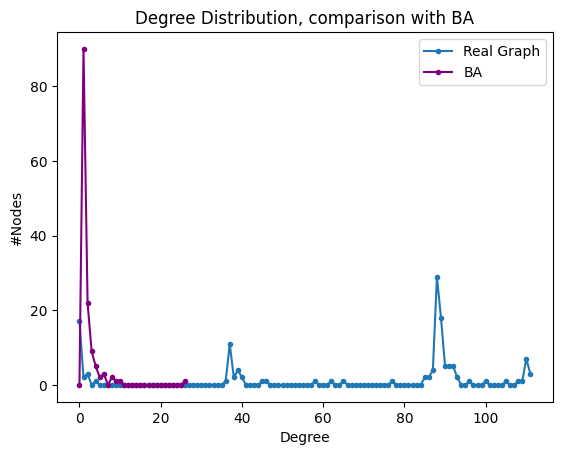

In [780]:
hist_ba = nx.degree_histogram(ba)


plt.plot(range(0, len(hist)), hist, ".-", label = 'Real Graph')
plt.title("Degree Distribution")
plt.xlabel("Degree")
plt.ylabel("#Nodes")
    
plt.plot(range(0, len(hist_ba)), hist_ba, ".-", label = 'BA', color = 'purple')
plt.title("Degree Distribution, comparison with BA")
plt.xlabel("Degree")
plt.ylabel("#Nodes")
plt.legend()
plt.show()

In [791]:
ba_n_nodes = ba.number_of_nodes()
ba_n_edges = ba.number_of_edges()
ba_avg_deg = sum(dict(ba.degree()).values())/float(len(ba))
ba_n_comps = nx.number_connected_components(ba)
ba_n_isol_nodes = len(list(nx.isolates(ba)))
ba_comps = list(nx.connected_components(ba)) # get a list of connected components (for decreasing size)
ba_avg_spl = nx.average_shortest_path_length(ba.subgraph(ba_comps[0])) #giant component
ba_diam = nx.diameter(ba.subgraph(ba_comps[0])) # we compute the diameter on the giant component
ba_avg_cc = nx.average_clustering(ba) # compute the global clustering coefficient
ba_density = nx.density(ba)

In [792]:
rows = [[' ','#nodes', '#edges', 'avg degree','#isol. nodes', '#conn. comps.','avg SPL','diameter', 'avg CC', 'Density'],
         ['Real',n_nodes,n_edges,avg_deg,n_isol_nodes,n_comps-n_isol_nodes, avg_spl, diam, avg_cc,density],
         ['ER',er_n_nodes,er_n_edges,er_avg_deg,er_n_isol_nodes,er_n_comps-er_n_isol_nodes, er_avg_spl, er_diam, er_avg_cc,er_density],
         ['BA',ba_n_nodes,ba_n_edges,ba_avg_deg,ba_n_isol_nodes,ba_n_comps-ba_n_isol_nodes, ba_avg_spl, ba_diam, ba_avg_cc,ba_density]]

print('ER GRAPH:')
print(tabulate(rows, headers='firstrow'))

table = Texttable()
table.set_deco(Texttable.HEADER | Texttable.VLINES)
table.add_rows(rows)

print(tabulate(list(zip(rows[0],rows[1],rows[2],rows[3])), headers='firstrow', tablefmt='latex', floatfmt=".2f"))


ER GRAPH:
        #nodes    #edges    avg degree    #isol. nodes    #conn. comps.    avg SPL    diameter    avg CC    Density
----  --------  --------  ------------  --------------  ---------------  ---------  ----------  --------  ---------
Real       136      4568       67.1765              17                1    1.37032           3  0.804177   0.497603
ER         136      4570       67.2059               0                1    1.50218           2  0.499206   0.497821
BA         136      3468       51                    0                1    1.62222           2  0.477869   0.377778
\begin{tabular}{lrrr}
\hline
               &    Real &      ER &      BA \\
\hline
 \#nodes        &  136.00 &  136.00 &  136.00 \\
 \#edges        & 4568.00 & 4570.00 & 3468.00 \\
 avg degree    &   67.18 &   67.21 &   51.00 \\
 \#isol. nodes  &   17.00 &    0.00 &    0.00 \\
 \#conn. comps. &    1.00 &    1.00 &    1.00 \\
 avg SPL       &    1.37 &    1.50 &    1.62 \\
 diameter      &    3.00 &    2.00

# Communities

9052
9052


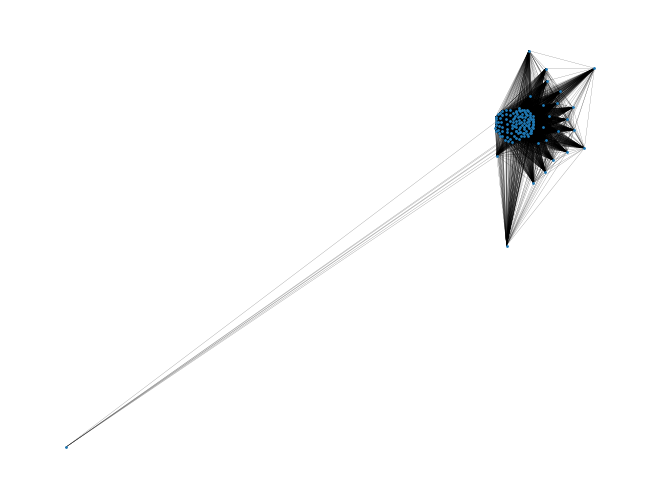

In [783]:
F = G.copy()
threshold = tresh
threshold = 0
print(F.number_of_edges())
F.remove_edges_from([(n1, n2) for n1, n2, w in F.edges(data="weight") if w < threshold])
print(F.number_of_edges())

nx.draw(F, node_size = 1, width = 0.1)
plt.show()

In [784]:
louvain = algorithms.louvain(F)

In [785]:
louvain.communities

[[0,
  1,
  2,
  3,
  4,
  5,
  6,
  9,
  13,
  14,
  15,
  16,
  17,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  28,
  30,
  31,
  34,
  35,
  36,
  37,
  39,
  40,
  41,
  42,
  44,
  46,
  47,
  51,
  53,
  54,
  55,
  56,
  57,
  58,
  60,
  64,
  65,
  68,
  69,
  70,
  71,
  73,
  75,
  76,
  78,
  79,
  80,
  83,
  84,
  86,
  87,
  88,
  91,
  92,
  93,
  94,
  95,
  97,
  98,
  99,
  100,
  101,
  102,
  103,
  104,
  106,
  107,
  110,
  111,
  112,
  113,
  116,
  117,
  119,
  120,
  121,
  122,
  123,
  124,
  125,
  126,
  129,
  133,
  134,
  135],
 [7,
  8,
  10,
  11,
  12,
  18,
  27,
  29,
  32,
  33,
  38,
  43,
  45,
  48,
  49,
  50,
  52,
  59,
  61,
  62,
  63,
  66,
  67,
  72,
  74,
  77,
  81,
  82,
  85,
  89,
  90,
  96,
  105,
  108,
  109,
  114,
  115,
  118,
  127,
  128,
  130,
  131,
  132]]

In [786]:
louvain.average_internal_degree(summary=False)

[92.0, 40.372093023255815]

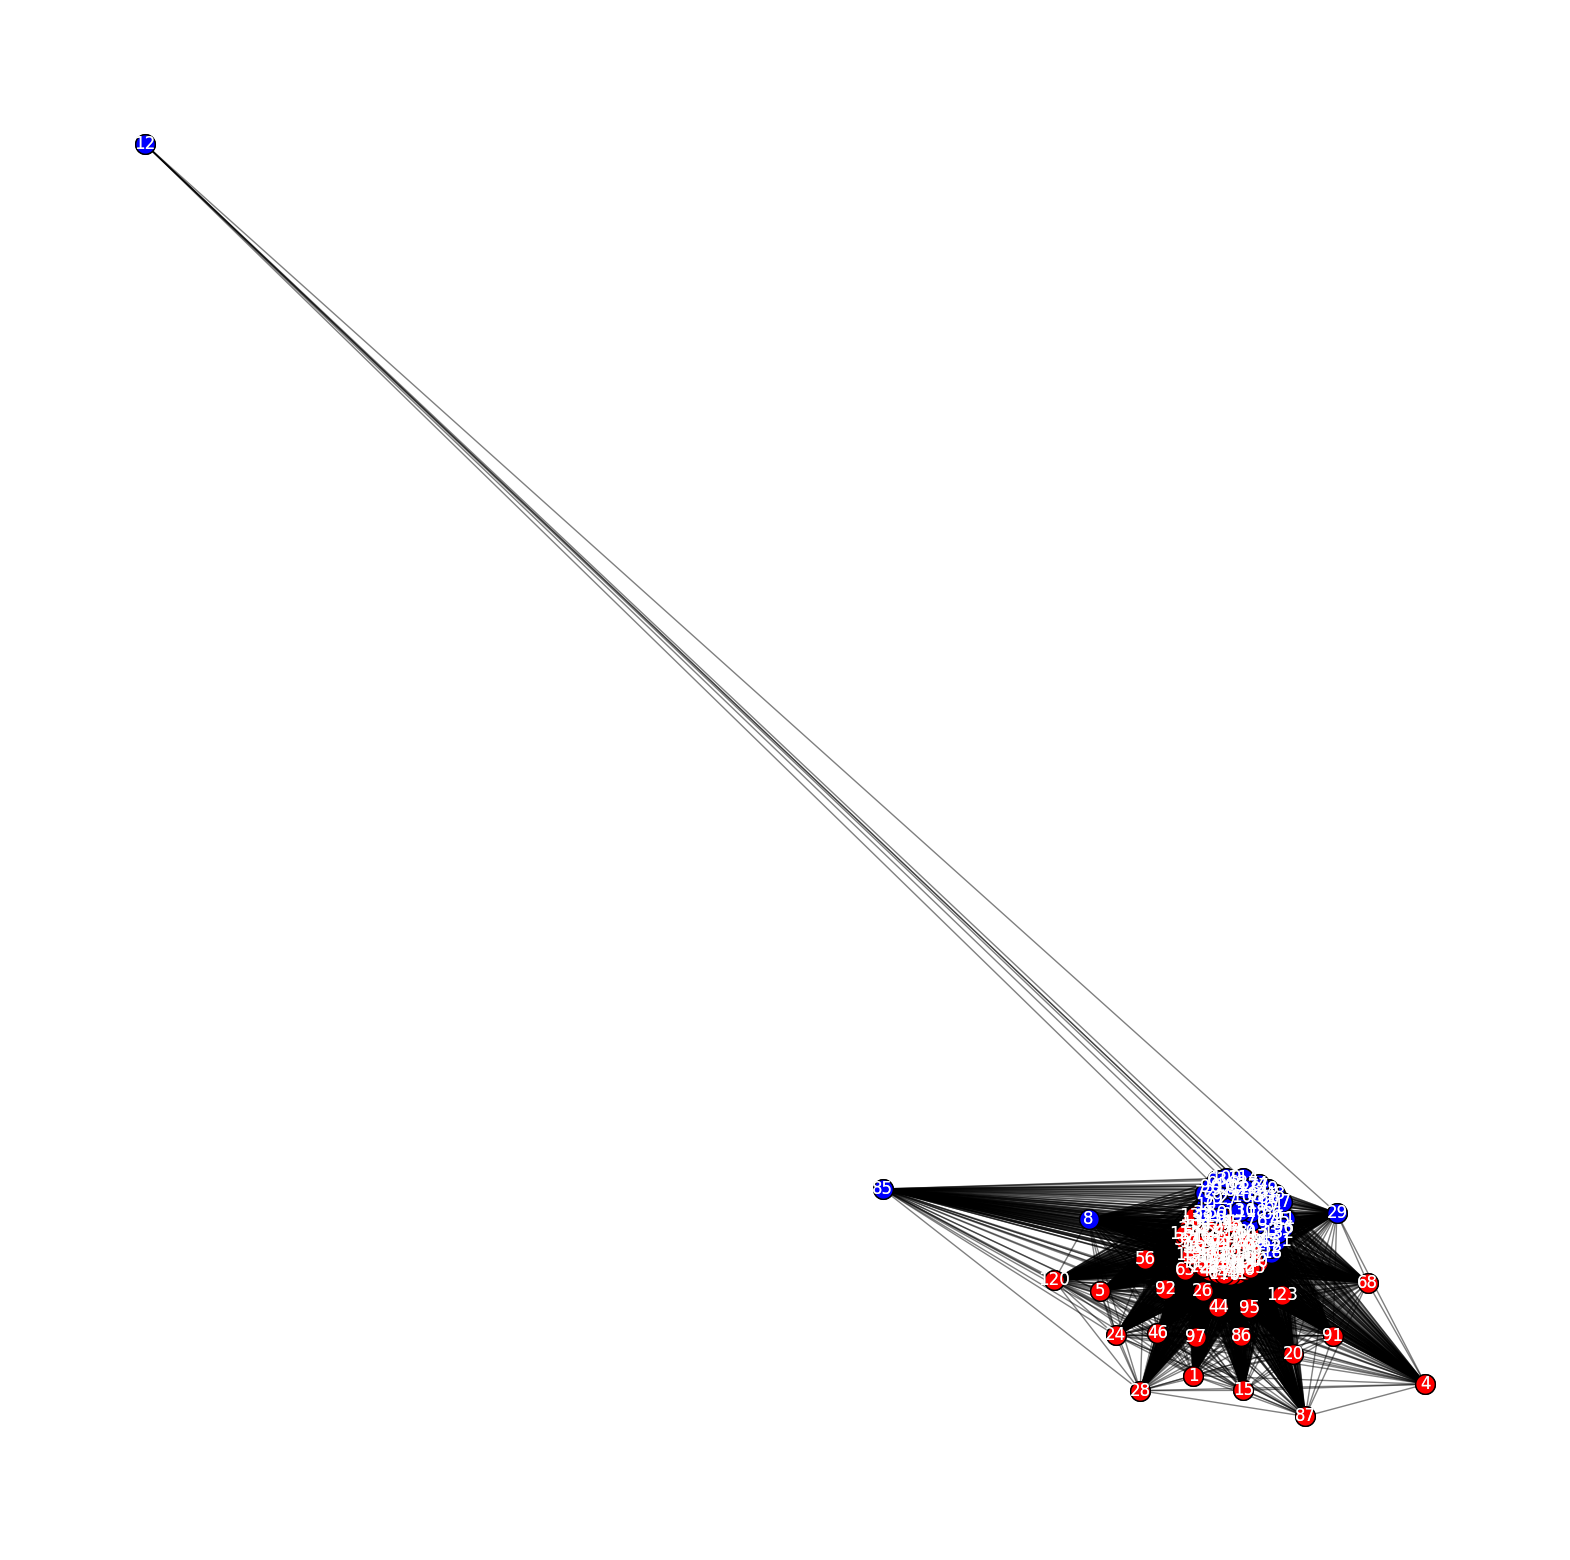

In [787]:
from cdlib import viz


pos = nx.spring_layout(F)
viz.plot_network_clusters(F, louvain, pos, figsize=(20, 20), plot_labels=True, min_size=5)